In [7]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import torch
import torch.nn as nn
from torch.distributions import Normal
from torch.distributions.kl import kl_divergence
import sys
sys.path.append('..')

from tqdm import tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


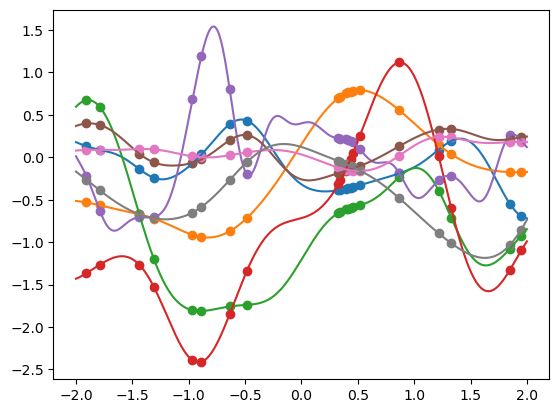

In [2]:
from data.gpdata import GPData
import matplotlib.pyplot as plt

sine_data_test = GPData(max_num_context=97, sigma_noise=5e-5)

batch = sine_data_test.generate_batch(batch_size=8, testing=True, device='cpu')

for i in range(8):
    x_target = batch.x_target[i].flatten()
    y_target = batch.y_target[i].flatten()
    plt.plot(x_target.numpy(), y_target.numpy())
for i in range(8):
    x_context = batch.x_context[i].flatten()
    y_context = batch.y_context[i].flatten()
    plt.scatter(x_context.numpy(), y_context.numpy())
plt.show()

NeuralProcess(
  (deterministic_encoder): DeterminisitcEncoder(
    (phi): BatchMLP(
      (mlp): Sequential(
        (0): Linear(in_features=2, out_features=128, bias=True)
        (1): ReLU()
        (2): Linear(in_features=128, out_features=128, bias=True)
        (3): ReLU()
        (4): Linear(in_features=128, out_features=128, bias=True)
        (5): ReLU()
        (6): Linear(in_features=128, out_features=128, bias=True)
        (7): ReLU()
        (8): Linear(in_features=128, out_features=128, bias=True)
        (9): ReLU()
        (10): Linear(in_features=128, out_features=128, bias=True)
        (11): Identity()
      )
    )
    (rho): Linear(in_features=128, out_features=128, bias=True)
  )
  (latent_encoder): LatentEncoder(
    (phi): BatchMLP(
      (mlp): Sequential(
        (0): Linear(in_features=2, out_features=128, bias=True)
        (1): ReLU()
        (2): Linear(in_features=128, out_features=128, bias=True)
        (3): ReLU()
        (4): Linear(in_features=128, 

  0%|          | 0/100001 [00:00<?, ?it/s]

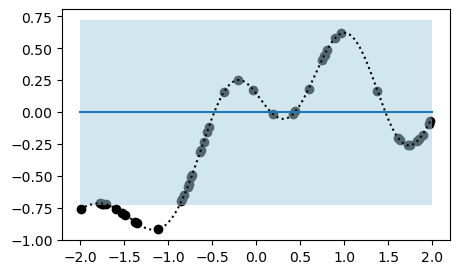

  0%|          | 386/100001 [00:11<51:09, 32.45it/s]  


KeyboardInterrupt: 

In [11]:
from src.plot import plot_predictive
from src.np import NeuralProcess

x_dim = 1
y_dim = 1
determ_dim = 128  # Dimension of representation of context points
latent_dim = 128  # Dimension of sampled latent variable
hidden_dim = 128  # Dimension of hidden layers in encoder and decoder
np = NeuralProcess(x_dim=x_dim,
                   y_dim=y_dim,
                   hidden_dim=hidden_dim,
                   latent_dim=latent_dim,
                   determ_dim=determ_dim,
                   n_h_layers_decoder=4,
                   n_h_layers_phi_latent_encoder=2,
                   n_h_layers_rho_latent_encoder=1,
                   n_h_layers_phi_determ_encoder=5,
                   n_h_layers_rho_determ_encoder=0,
                   use_deterministic_path=True,
                   use_latent_self_attn=False,
                   use_determ_self_attn=False,
                   use_determ_cross_attn=False
                   )
print(np)
print(sum(p.numel() for p in np.parameters() if p.requires_grad))

#data = SineData(max_num_context=30, random_kernel_parameters=True)
optimiser = torch.optim.Adam(np.parameters(), lr=3e-4)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device {device}")
np.to(device)


data = GPData(max_num_context=97)
train_loss = []
train_nll = []
avg_loss_fast = 0
avg_loss_slow = 0
avg_nll_fast = 0
for iter in tqdm(range(100000+1)):
    np.training = True
    optimiser.zero_grad()

    batch = data.generate_batch(batch_size=16, device=device)
    p_y_pred, loss, log_lik = np(x_context=batch.x_context,
                        y_context=batch.y_context,
                        x_target=batch.x_target,
                        knowledge=None,
                        y_target=batch.y_target)

    loss.backward()
    optimiser.step()
    train_loss.append(loss.item())

    avg_loss_slow += loss.item()
    avg_loss_fast += loss.item()
    train_nll.append(log_lik.mean().item())
    avg_nll_fast += log_lik.mean().item()
    
    if iter % 1000 == 0 and iter > 0:
        print(f"iter {iter+1}: Avg. Loss = {avg_loss_fast/1000}")
        #print(f"iter. loss = {loss.item()}, iter. Loss2 (not being backpropped on) = {loss2.item()}")
        avg_loss_fast = 0 
        print(f"iter {iter+1}: Avg. NLL = {avg_nll_fast/1000}")
        avg_nll_fast = 0
    if iter % 10000 == 0 and iter > 0:
        print(f"iter {iter+1}: Avg. Loss SLOW = {avg_loss_slow/1000}")
        avg_loss_slow = 0 
    if iter % 2000 == 0:
        np.training = False
        batch = data.generate_batch(batch_size=1, testing=True, device=np.device)
        plot_predictive(np, batch, knowledge=None, save=False, iter=None)
        np.training = True

plt.plot(train_loss, label='train_loss')
window = 50
plt.plot([sum(train_loss[i:i+window])/window for i in range(len(train_loss)-window)], label=f'train_loss_{window}_smooth')
plt.legend()
plt.show()

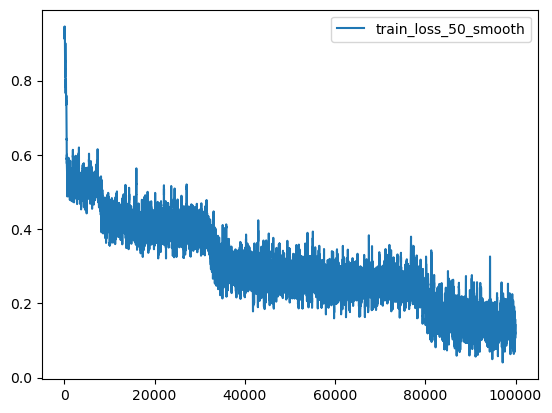

In [8]:
# plt.plot(train_loss, label='train_loss')
window = 50
plt.plot([sum(train_loss[i:i+window])/window for i in range(len(train_loss)-window)], label=f'train_loss_{window}_smooth')
plt.legend()
plt.show()

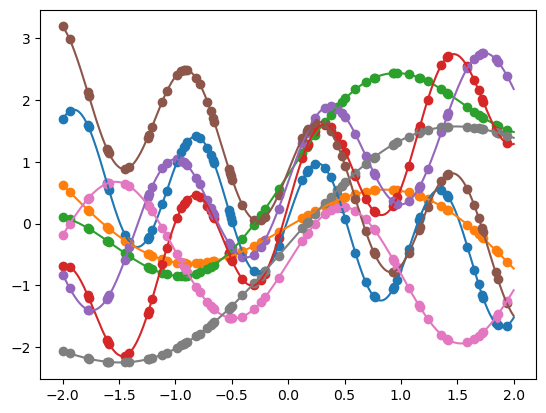

torch.Size([8, 1])


In [56]:
from data.sinedata import SineData
import matplotlib.pyplot as plt

sine_data_test = SineData(max_num_context=97, noise_scale=5e-5)

batch, knowledge = sine_data_test.generate_batch(batch_size=8, testing=True, device='cpu')

for i in range(8):
    x_target = batch.x_target[i].flatten()
    y_target = batch.y_target[i].flatten()
    plt.plot(x_target.numpy(), y_target.numpy())
for i in range(8):
    x_context = batch.x_context[i].flatten()
    y_context = batch.y_context[i].flatten()
    plt.scatter(x_context.numpy(), y_context.numpy())
plt.show()

print(knowledge[2].shape)

NeuralProcess(
  (latent_encoder): LatentEncoder(
    (phi): BatchMLP(
      (mlp): Sequential(
        (0): Linear(in_features=2, out_features=50, bias=True)
        (1): ReLU()
        (2): Linear(in_features=50, out_features=50, bias=True)
        (3): ReLU()
        (4): Linear(in_features=50, out_features=50, bias=True)
        (5): Identity()
      )
    )
    (rho): BatchMLP(
      (mlp): Sequential(
        (0): Linear(in_features=50, out_features=50, bias=True)
        (1): ReLU()
        (2): Linear(in_features=50, out_features=100, bias=True)
        (3): Identity()
      )
    )
  )
  (decoder): Decoder(
    (target_transform): Linear(in_features=1, out_features=50, bias=True)
    (decoder): BatchMLP(
      (mlp): Sequential(
        (0): Linear(in_features=100, out_features=50, bias=True)
        (1): ReLU()
        (2): Linear(in_features=50, out_features=50, bias=True)
        (3): ReLU()
        (4): Linear(in_features=50, out_features=50, bias=True)
        (5): ReLU()

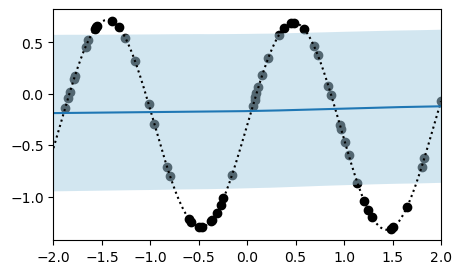

iter 1001: Avg. Loss = 1.0641487488746644
iter 2001: Avg. Loss = 0.7657333945035935
iter 3001: Avg. Loss = 0.7401649373173713
iter 4001: Avg. Loss = 0.709771315574646
iter 5001: Avg. Loss = 0.7057590469419956
Test loss: 0.671392918407917
iter 6001: Avg. Loss = 0.6886724998056889
iter 7001: Avg. Loss = 0.679414520829916
iter 8001: Avg. Loss = 0.6831060515642167
iter 9001: Avg. Loss = 0.675982640504837
iter 10001: Avg. Loss = 0.654388975918293
Test loss: 0.5833167722374201
iter 10001: Avg. Loss SLOW = 7.367142131835222
iter 11001: Avg. Loss = 0.6093300860226154
iter 12001: Avg. Loss = 0.5571535343676806
iter 13001: Avg. Loss = 0.5144591350834816
iter 14001: Avg. Loss = 0.4852418884113431
iter 15001: Avg. Loss = 0.4661212791642174
Test loss: 0.3497470297892578
iter 16001: Avg. Loss = 0.46110365783143786
iter 17001: Avg. Loss = 0.436396653605625
iter 18001: Avg. Loss = 0.4083729581316002
iter 19001: Avg. Loss = 0.38079576309444385
iter 20001: Avg. Loss = 0.3935019971361471
Test loss: 0.257

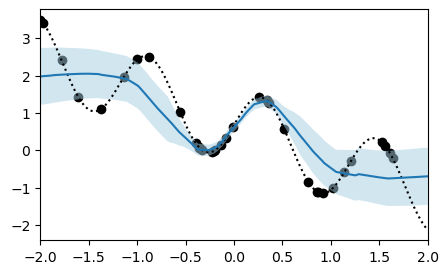

iter 21001: Avg. Loss = 0.35842165687982924
iter 22001: Avg. Loss = 0.34028154455061305
iter 23001: Avg. Loss = 0.3477242577332945
iter 24001: Avg. Loss = 0.3388078087263275
iter 25001: Avg. Loss = 0.332790416249074
Test loss: 0.20619441040420497
iter 26001: Avg. Loss = 0.32033102493546906
iter 27001: Avg. Loss = 0.30749345663771965
iter 28001: Avg. Loss = 0.26622097321266486
iter 29001: Avg. Loss = 0.2702009071695211
iter 30001: Avg. Loss = 0.2733321197801242
Test loss: 0.07224588526006119
iter 30001: Avg. Loss SLOW = 3.155604165874637
iter 31001: Avg. Loss = 0.25462399584171724
iter 32001: Avg. Loss = 0.23849403646067366
iter 33001: Avg. Loss = 0.24264537843194559
iter 34001: Avg. Loss = 0.231913709805056
iter 35001: Avg. Loss = 0.21186263753473758
Test loss: 0.00434961292279695
iter 36001: Avg. Loss = 0.19886063341251428
iter 37001: Avg. Loss = 0.2186062121391442
iter 38001: Avg. Loss = 0.1964773000543064
iter 39001: Avg. Loss = 0.17038335975809604
iter 40001: Avg. Loss = 0.22488500

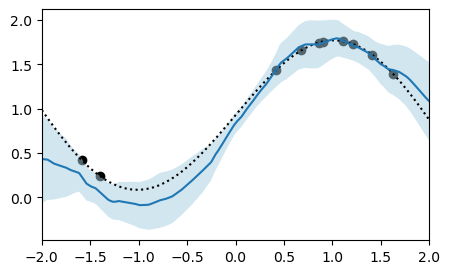

iter 41001: Avg. Loss = 0.1776978656891006
iter 42001: Avg. Loss = 0.16477609475620555
iter 43001: Avg. Loss = 0.16124626398237887
iter 44001: Avg. Loss = 0.16759754867991433
iter 45001: Avg. Loss = 0.15032839229280945
Test loss: -0.02359804527295637
iter 46001: Avg. Loss = 0.1625879689784415
iter 47001: Avg. Loss = 0.14702935842296574
iter 48001: Avg. Loss = 0.12930357250152155
iter 49001: Avg. Loss = 0.13132612400655852
iter 50001: Avg. Loss = 0.12335311424801534
Test loss: 0.02985730540388613
iter 50001: Avg. Loss SLOW = 1.5152463035579116
iter 51001: Avg. Loss = 0.14813362119639986
iter 52001: Avg. Loss = 0.14318596596620045
iter 53001: Avg. Loss = 0.10834191963412741
iter 54001: Avg. Loss = 0.10851498800485933
iter 55001: Avg. Loss = 0.12366166715348481
Test loss: -0.07263036956116412
iter 56001: Avg. Loss = 0.10243220872647361
iter 57001: Avg. Loss = 0.09335073447966716
iter 58001: Avg. Loss = 0.10970369554057834
iter 59001: Avg. Loss = 0.09602428221730225
iter 60001: Avg. Loss =

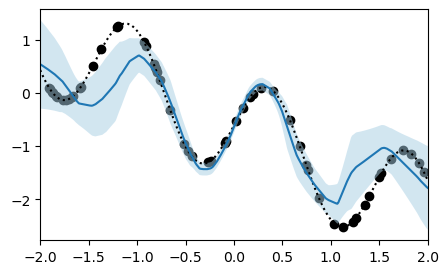

iter 61001: Avg. Loss = 0.08209430424828315
iter 62001: Avg. Loss = 0.08942512548343802
iter 63001: Avg. Loss = 0.0975079886626272
iter 64001: Avg. Loss = 0.08650081449066784
iter 65001: Avg. Loss = 0.07678617626670166
Test loss: -0.09256670377856062
iter 66001: Avg. Loss = 0.06696060872638554
iter 67001: Avg. Loss = 0.07100919589537079
iter 68001: Avg. Loss = 0.05394539081239054
iter 69001: Avg. Loss = 0.07347184317966457
iter 70001: Avg. Loss = 0.0636918768727337
Test loss: -0.2048163852156722
iter 70001: Avg. Loss SLOW = 0.761393324638263
iter 71001: Avg. Loss = 0.057989686226628694
iter 72001: Avg. Loss = 0.04940309210178384
iter 73001: Avg. Loss = 0.030491012603226408
iter 74001: Avg. Loss = 0.05026827823375061
iter 75001: Avg. Loss = 0.03291394207166741
Test loss: -0.15195914386508957
iter 76001: Avg. Loss = 0.0067905397549038755
iter 77001: Avg. Loss = 0.0004037666774675017
iter 78001: Avg. Loss = 0.0024099601407069713
iter 79001: Avg. Loss = -0.022390703556258815
iter 80001: Av

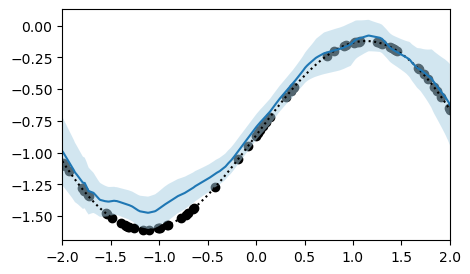

iter 81001: Avg. Loss = -0.063254527492737
iter 82001: Avg. Loss = -0.03359965844408725
iter 83001: Avg. Loss = -0.08002856056214659
iter 84001: Avg. Loss = -0.061712719956878576
iter 85001: Avg. Loss = -0.074937378522769
Test loss: -0.3125248984594364
iter 86001: Avg. Loss = -0.07315250322748033
iter 87001: Avg. Loss = -0.08674251896317582
iter 88001: Avg. Loss = -0.08894746727409074
iter 89001: Avg. Loss = -0.10361397149428377
iter 90001: Avg. Loss = -0.12613947851213744
Test loss: -0.29620724071215954
iter 90001: Avg. Loss SLOW = -0.7921287844497865
iter 91001: Avg. Loss = -0.14324925960967083
iter 92001: Avg. Loss = -0.10733743215969298
iter 93001: Avg. Loss = -0.14911075933475512
iter 94001: Avg. Loss = -0.13796995087433606
iter 95001: Avg. Loss = -0.14943812557077035
Test loss: -0.4244221385286655
iter 96001: Avg. Loss = -0.1429903116706264
iter 97001: Avg. Loss = -0.1613570630653994
iter 98001: Avg. Loss = -0.13504933928581886
iter 99001: Avg. Loss = -0.1545961069756595
iter 100

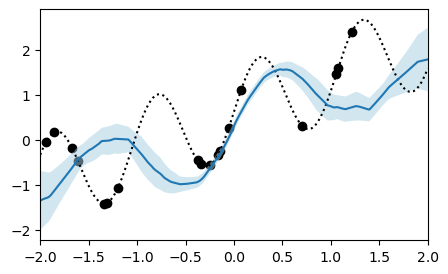

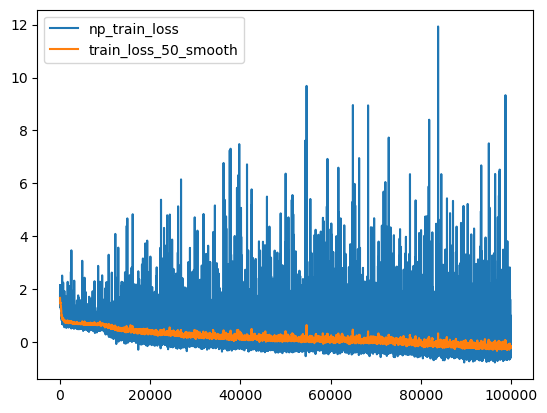

In [118]:
x_dim = 1
y_dim = 1
determ_dim = 50  # Dimension of representation of context points
latent_dim = 50  # Dimension of sampled latent variable
hidden_dim = 50  # Dimension of hidden layers in encoder and decoder
np = NeuralProcess(x_dim=x_dim,
                   y_dim=y_dim,
                   hidden_dim=hidden_dim,
                   latent_dim=latent_dim,
                   determ_dim=determ_dim,
                   n_h_layers_decoder=3,
                   n_h_layers_phi_latent_encoder=2,
                   n_h_layers_rho_latent_encoder=1,
                   n_h_layers_phi_determ_encoder=6,
                   n_h_layers_rho_determ_encoder=0,
                   use_deterministic_path=False)
print(np)
print(sum(p.numel() for p in np.parameters() if p.requires_grad))

#data = SineData(max_num_context=30, random_kernel_parameters=True)
optimiser = torch.optim.Adam(np.parameters(), lr=3e-4)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device {device}")
np.to(device)


data = SineData(max_num_context=97, noise_scale=5e-5, return_knowledge=True)
np_train_loss = []
np_avg_test_losses = []
avg_loss_fast = 0
avg_loss_slow = 0
for iter in range(100000+1):
    np.training = True
    optimiser.zero_grad()

    batch, knowledge = data.generate_batch(batch_size=16, device=device)
    p_y_pred, loss = np(batch.x_context, batch.y_context, batch.x_target, None, batch.y_target)

    loss.backward()
    optimiser.step()
    np_train_loss.append(loss.item())

    avg_loss_slow += loss.item()
    avg_loss_fast += loss.item()
    
    if iter % 1000 == 0 and iter > 0:
        print(f"iter {iter+1}: Avg. Loss = {avg_loss_fast/1000}")
        #print(f"iter. loss = {loss.item()}, iter. Loss2 (not being backpropped on) = {loss2.item()}")
        avg_loss_fast = 0 
    if iter % 5000 == 0:
        np_avg_test_losses.append(test(np, num_batches=1000))
    if iter % 10000 == 0 and iter > 0:
        print(f"iter {iter+1}: Avg. Loss SLOW = {avg_loss_slow/1000}")
        avg_loss_slow = 0 
    if iter % 20000 == 0:
        np.training = False
        batch, knowledge = data.generate_batch(batch_size=1, testing=True, device=np.device)
        plot_predictive(np, batch, knowledge=None, save=False, iter=None)
        np.training = True

plt.plot(np_train_loss, label='np_train_loss')
window = 50
plt.plot([sum(np_train_loss[i:i+window])/window for i in range(len(np_train_loss)-window)], label=f'train_loss_{window}_smooth')
plt.legend()
plt.show()

LUPINeuralProcess(
  (latent_encoder): LatentEncoder(
    (phi): BatchMLP(
      (mlp): Sequential(
        (0): Linear(in_features=2, out_features=50, bias=True)
        (1): ReLU()
        (2): Linear(in_features=50, out_features=50, bias=True)
        (3): ReLU()
        (4): Linear(in_features=50, out_features=50, bias=True)
        (5): Identity()
      )
    )
    (rho): BatchMLP(
      (mlp): Sequential(
        (0): Linear(in_features=50, out_features=50, bias=True)
        (1): ReLU()
        (2): Linear(in_features=50, out_features=100, bias=True)
        (3): Identity()
      )
    )
  )
  (decoder): Decoder(
    (target_transform): Linear(in_features=1, out_features=50, bias=True)
    (decoder): BatchMLP(
      (mlp): Sequential(
        (0): Linear(in_features=100, out_features=50, bias=True)
        (1): ReLU()
        (2): Linear(in_features=50, out_features=50, bias=True)
        (3): ReLU()
        (4): Linear(in_features=50, out_features=50, bias=True)
        (5): Re

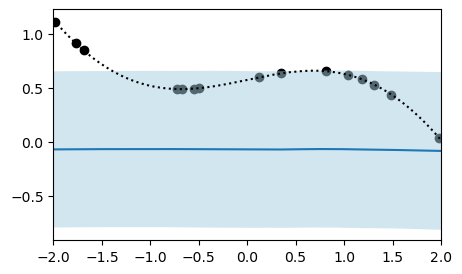

iter 1001: Avg. Loss = 1.1775502184033393
iter 2001: Avg. Loss = 0.7739194121360778
iter 3001: Avg. Loss = 0.7476671649217606
iter 4001: Avg. Loss = 0.7253426102995872
iter 5001: Avg. Loss = 0.6457797684967518
Test loss: 0.5118730428852141
iter 6001: Avg. Loss = 0.5883036236315966
iter 7001: Avg. Loss = 0.5330031372904778
iter 8001: Avg. Loss = 0.4820114991925657
iter 9001: Avg. Loss = 0.4308668033313006
iter 10001: Avg. Loss = 0.41466879506409166
Test loss: 0.2633093487653532
iter 10001: Avg. Loss SLOW = 6.5191130327675495
iter 11001: Avg. Loss = 0.3702403769250959
iter 12001: Avg. Loss = 0.34700595667702144
iter 13001: Avg. Loss = 0.3067369678132236
iter 14001: Avg. Loss = 0.2911394807970355
iter 15001: Avg. Loss = 0.2779012667266652
Test loss: 0.17515414123919618
iter 16001: Avg. Loss = 0.2688107133394733
iter 17001: Avg. Loss = 0.26307917366997574
iter 18001: Avg. Loss = 0.25157617818709693
iter 19001: Avg. Loss = 0.23098278032930103
iter 20001: Avg. Loss = 0.21344611215153053
Test

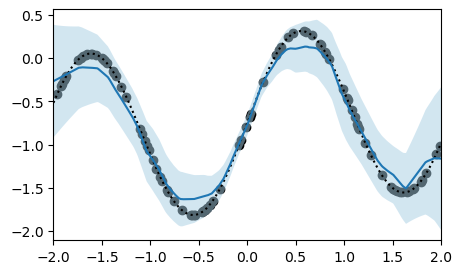

iter 21001: Avg. Loss = 0.21858975208102494
iter 22001: Avg. Loss = 0.22571871519859996
iter 23001: Avg. Loss = 0.2065323063877877
iter 24001: Avg. Loss = 0.154634652843597
iter 25001: Avg. Loss = 0.18291322937967197
Test loss: -0.008091248350639945
iter 26001: Avg. Loss = 0.1573414606700826
iter 27001: Avg. Loss = 0.18645221721372582
iter 28001: Avg. Loss = 0.19326554598398799
iter 29001: Avg. Loss = 0.1561386754295818
iter 30001: Avg. Loss = 0.1270002709484486
Test loss: -0.09283602448045712
iter 30001: Avg. Loss SLOW = 1.8085868261365083
iter 31001: Avg. Loss = 0.12314684370777104
iter 32001: Avg. Loss = 0.13253161358193027
iter 33001: Avg. Loss = 0.1288671613848419
iter 34001: Avg. Loss = 0.12224480669287732
iter 35001: Avg. Loss = 0.1248709609665093
Test loss: -0.08535950737776875
iter 36001: Avg. Loss = 0.11936020633761654
iter 37001: Avg. Loss = 0.11826003955824126
iter 38001: Avg. Loss = 0.10122735342020406
iter 39001: Avg. Loss = 0.08758487036498264
iter 40001: Avg. Loss = 0.0

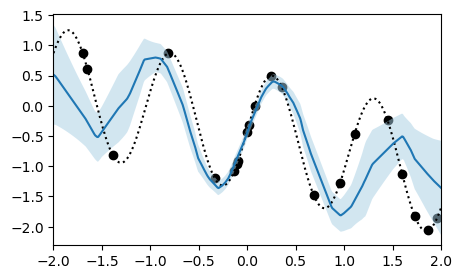

iter 41001: Avg. Loss = 0.08144119645335013
iter 42001: Avg. Loss = 0.08194048540189397
iter 43001: Avg. Loss = 0.07736919665944879
iter 44001: Avg. Loss = 0.08982748125134093
iter 45001: Avg. Loss = 0.055020982947156884
Test loss: -0.1587691193947976
iter 46001: Avg. Loss = 0.04342569342612114
iter 47001: Avg. Loss = 0.0386311415170494
iter 48001: Avg. Loss = 0.03744786225002099
iter 49001: Avg. Loss = 0.02814721653713423
iter 50001: Avg. Loss = 0.05428663433451766
Test loss: -0.14591394310747274
iter 50001: Avg. Loss SLOW = 0.5875378907780341
iter 51001: Avg. Loss = 0.03014308106122189
iter 52001: Avg. Loss = 0.03988492588252757
iter 53001: Avg. Loss = 0.014159614231859451
iter 54001: Avg. Loss = 0.010672784566806513
iter 55001: Avg. Loss = 0.020194459381498747
Test loss: -0.20454213039047317
iter 56001: Avg. Loss = 0.05333823884658705
iter 57001: Avg. Loss = 0.016931946662571137
iter 58001: Avg. Loss = -0.0036968225067248567
iter 59001: Avg. Loss = -0.004199768583348486
iter 60001: 

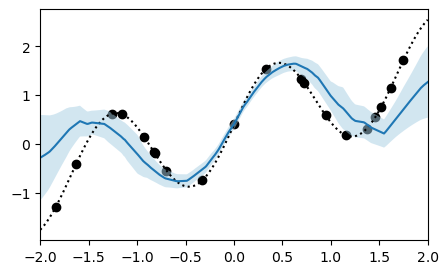

iter 61001: Avg. Loss = -0.020189117538262507
iter 62001: Avg. Loss = -0.025057770019644522
iter 63001: Avg. Loss = -0.0427519072239811
iter 64001: Avg. Loss = -0.020551703095727136
iter 65001: Avg. Loss = 0.010019529420445906
Test loss: -0.2065195371210284
iter 66001: Avg. Loss = -0.042000479333364635
iter 67001: Avg. Loss = -0.06720286535407649
iter 68001: Avg. Loss = -0.041842151581207875
iter 69001: Avg. Loss = -0.05380744226492243
iter 70001: Avg. Loss = -0.0420209391930839
Test loss: -0.24134728149778675
iter 70001: Avg. Loss SLOW = -0.3454048461838247
iter 71001: Avg. Loss = -0.07546423576267261
iter 72001: Avg. Loss = -0.04397533558611758
iter 73001: Avg. Loss = -0.05603200106692384
iter 74001: Avg. Loss = -0.09974700829404173
iter 75001: Avg. Loss = -0.06696231713582529
Test loss: -0.3701436930413256
iter 76001: Avg. Loss = -0.12827054798230528
iter 77001: Avg. Loss = -0.10569490229606163
iter 78001: Avg. Loss = -0.07956185926875332
iter 79001: Avg. Loss = -0.13403089061142237

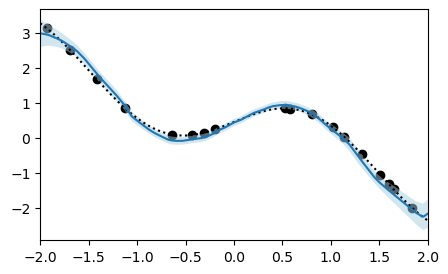

iter 81001: Avg. Loss = -0.15414713061915244
iter 82001: Avg. Loss = -0.19452416479447857
iter 83001: Avg. Loss = -0.1803470719369361
iter 84001: Avg. Loss = -0.18860063423152315
iter 85001: Avg. Loss = -0.20315351341517998
Test loss: -0.4965193617986515
iter 86001: Avg. Loss = -0.20001837174390674
iter 87001: Avg. Loss = -0.24301227673453105
iter 88001: Avg. Loss = -0.2364097517255286
iter 89001: Avg. Loss = -0.22051160763649386
iter 90001: Avg. Loss = -0.2249281207623717
Test loss: -0.47839442749507727
iter 90001: Avg. Loss SLOW = -2.045652643600102
iter 91001: Avg. Loss = -0.2957202146091149
iter 92001: Avg. Loss = -0.26681359971617347
iter 93001: Avg. Loss = -0.24817615318484604
iter 94001: Avg. Loss = -0.2675284315864701
iter 95001: Avg. Loss = -0.2949517457468901
Test loss: -0.4313522140923888
iter 96001: Avg. Loss = -0.30993309297342786
iter 97001: Avg. Loss = -0.32585092253121545
iter 98001: Avg. Loss = -0.31383513930027945
iter 99001: Avg. Loss = -0.3169271892812685
iter 10000

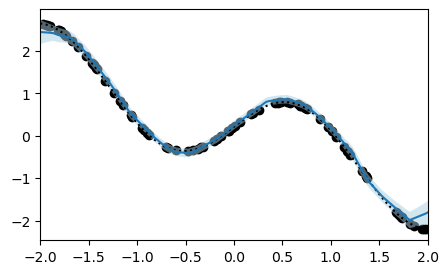

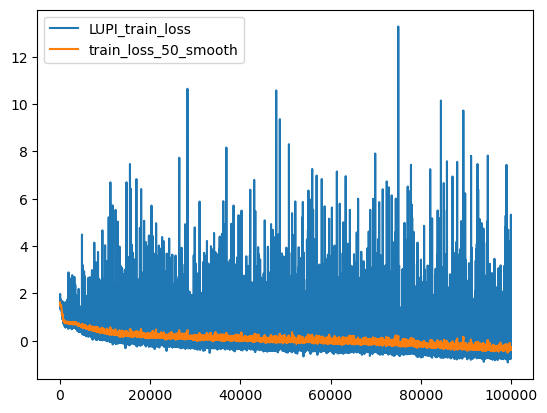

In [115]:
from src.LUPInp import LUPINeuralProcess
x_dim = 1
y_dim = 1
determ_dim = 50  # Dimension of representation of context points
latent_dim = 50  # Dimension of sampled latent variable
hidden_dim = 50  # Dimension of hidden layers in encoder and decoder
LUPI_np = LUPINeuralProcess(x_dim=x_dim,
                   y_dim=y_dim,
                   knowledge_dim=3,
                   hidden_dim=hidden_dim,
                   latent_dim=latent_dim,
                   determ_dim=determ_dim,
                   n_h_layers_decoder=3,
                   n_h_layers_knowledge_decoder=3,
                   n_h_layers_phi_latent_encoder=2,
                   n_h_layers_rho_latent_encoder=1,
                   n_h_layers_phi_determ_encoder=6,
                   n_h_layers_rho_determ_encoder=0,
                   use_deterministic_path=False)
print(LUPI_np)
print(sum(p.numel() for p in LUPI_np.parameters() if p.requires_grad))

#data = SineData(max_num_context=30, random_kernel_parameters=True)
optimiser = torch.optim.Adam(LUPI_np.parameters(), lr=3e-4)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device {device}")
LUPI_np.to(device)


data = SineData(max_num_context=97, noise_scale=5e-5, return_knowledge=True)
LUPI_train_loss = []
LUPI_np_avg_losses = []
avg_loss_fast = 0
avg_loss_slow = 0
for iter in range(100000+1):
    LUPI_np.training = True
    optimiser.zero_grad()

    batch, knowledge = data.generate_batch(batch_size=16, device=device)
    knowledge = torch.cat([knowledge[0], knowledge[1], knowledge[2]], dim=-1).unsqueeze(1).to(device) # Shape (batch_size, 1, knowledge_dim)
    assert knowledge.shape == (16, 1, 3)
    p_y_pred, loss, knowledge_loss = LUPI_np(batch.x_context, batch.y_context, batch.x_target, knowledge, batch.y_target)

    BETA = 1
    total_loss = loss + BETA * knowledge_loss
    total_loss.backward()
    optimiser.step()
    LUPI_train_loss.append(loss.item())

    avg_loss_slow += loss.item()
    avg_loss_fast += loss.item()
    
    if iter % 1000 == 0 and iter > 0:
        print(f"iter {iter+1}: Avg. Loss = {avg_loss_fast/1000}")
        #print(f"iter. loss = {loss.item()}, iter. Loss2 (not being backpropped on) = {loss2.item()}")
        avg_loss_fast = 0 
    if iter % 5000 == 0:
        LUPI_np_avg_losses.append(test(LUPI_np, num_batches=1000))
    if iter % 10000 == 0 and iter > 0:
        print(f"iter {iter+1}: Avg. Loss SLOW = {avg_loss_slow/1000}")
        avg_loss_slow = 0 
    if iter % 20000 == 0:
        LUPI_np.training = False
        batch, knowledge = data.generate_batch(batch_size=1, testing=True, device=LUPI_np.device)
        plot_predictive(LUPI_np, batch, knowledge=None, save=False, iter=None)
        LUPI_np.training = True

plt.plot(LUPI_train_loss, label='LUPI_train_loss')
window = 50
plt.plot([sum(LUPI_train_loss[i:i+window])/window for i in range(len(LUPI_train_loss)-window)], label=f'train_loss_{window}_smooth')
plt.legend()
plt.show()

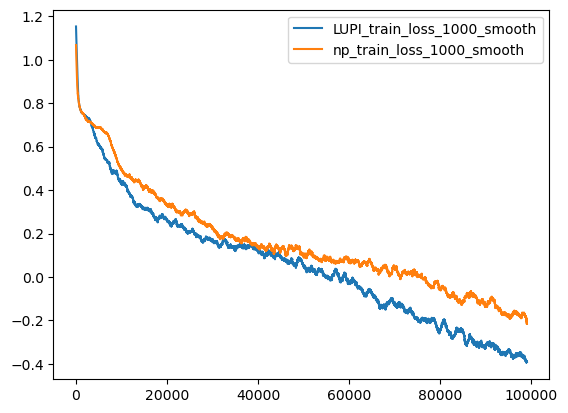

In [76]:
# plt.plot(train_loss, label='train_loss')
window = 1000
plt.plot([sum(LUPI_train_loss[i:i+window])/window for i in range(len(LUPI_train_loss)-window)], label=f'LUPI_train_loss_{window}_smooth')
plt.plot([sum(np_train_loss[i:i+window])/window for i in range(len(np_train_loss)-window)], label=f'np_train_loss_{window}_smooth')
plt.legend()
plt.show()

In [109]:
def generate_knowledge(abc: tuple, device):
    """
    abc: tuple[torch.Tensor, torch.Tensor, torch.Tensor]
        Shape (batch_size, y_size)
    Knowledge can be none, a, b, c, ab, ac, bc 
    each vector is one-hot encoding of the parameter type with value appended to end
    e.g. if knowledge is a=1, b=0.5 then k = [1, 0, 0, 1], [0, 1, 0, 0.5]
    Returns 
    -------
    knowledge: torch.Tensor
        Shape (batch_size, num_knowledge_points, 4)
    """
    # sample types of knowledge to use as 3-vector. i.e. if ab then [1, 1, 0] if none then [0, 0, 0] etc
    binary_vector = torch.randint(0, 2, (3,))
    total_knowledge = []
    if binary_vector.sum() == 0:
        return None
    if binary_vector[0] == 1:
        # make [1, 0, 0, a]
        a = abc[0].unsqueeze(1)
        knowledge = torch.cat([torch.ones_like(a), torch.zeros_like(a), torch.zeros_like(a), a], dim=-1)
        total_knowledge.append(knowledge)
    if binary_vector[1] == 1:
        # make [0, 1, 0, b]
        b = abc[1].unsqueeze(1)
        knowledge = torch.cat([torch.zeros_like(b), torch.ones_like(b), torch.zeros_like(b), b], dim=-1)
        total_knowledge.append(knowledge)
    if binary_vector[2] == 1:
        # make [0, 0, 1, c]
        c = abc[2].unsqueeze(1)
        knowledge = torch.cat([torch.zeros_like(c), torch.zeros_like(c), torch.ones_like(c), c], dim=-1)
        total_knowledge.append(knowledge)
    total_knowledge = torch.cat(total_knowledge, dim=1)
    return total_knowledge.to(device)

def test(model, num_batches=100):

    data = SineData(max_num_context=97, noise_scale=5e-5, return_knowledge=True)
    with torch.no_grad():

        losses = []
        for _ in range(num_batches):
            batch, _ = data.generate_batch(batch_size=8, testing=True, device=model.device)
            _, loss = model(batch.x_context, batch.y_context, batch.x_target, None, batch.y_target)
            losses.append(loss.item())

    avg_loss = sum(losses) / num_batches
    print(f"Test loss: {avg_loss}")
    return avg_loss


NeuralProcess(
  (knowledge_encoder): KnowledgeEncoder(
    (phi): BatchMLP(
      (mlp): Sequential(
        (0): Linear(in_features=4, out_features=50, bias=True)
        (1): ReLU()
        (2): Linear(in_features=50, out_features=50, bias=True)
        (3): ReLU()
        (4): Linear(in_features=50, out_features=50, bias=True)
        (5): Identity()
      )
    )
    (rho): BatchMLP(
      (mlp): Sequential(
        (0): Linear(in_features=50, out_features=50, bias=True)
        (1): ReLU()
        (2): Linear(in_features=50, out_features=50, bias=True)
        (3): ReLU()
        (4): Linear(in_features=50, out_features=50, bias=True)
        (5): Identity()
      )
    )
  )
  (latent_encoder): LatentEncoder(
    (phi): BatchMLP(
      (mlp): Sequential(
        (0): Linear(in_features=2, out_features=50, bias=True)
        (1): ReLU()
        (2): Linear(in_features=50, out_features=50, bias=True)
        (3): ReLU()
        (4): Linear(in_features=50, out_features=50, bias=Tru

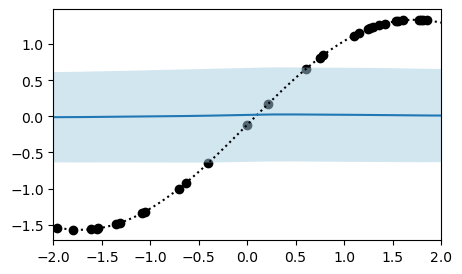

iter 1001: Avg. Loss = 1.0493306793570518
iter 2001: Avg. Loss = 0.7463729662299157
iter 3001: Avg. Loss = 0.6314998282715678
iter 4001: Avg. Loss = 0.5372728660840076
iter 5001: Avg. Loss = 0.4159476677076018
Test loss: 0.684238793939352
iter 6001: Avg. Loss = 0.3399833605196327
iter 7001: Avg. Loss = 0.2853642363444087
iter 8001: Avg. Loss = 0.28606289044078587
iter 9001: Avg. Loss = 0.25253807723082716
iter 10001: Avg. Loss = 0.20843741329672047
Test loss: 0.5888603770285845
iter 10001: Avg. Loss SLOW = 4.75280998548252
iter 11001: Avg. Loss = 0.20674713492696173
iter 12001: Avg. Loss = 0.1839960670224391
iter 13001: Avg. Loss = 0.14770744995347923
iter 14001: Avg. Loss = 0.14592592095956206
iter 15001: Avg. Loss = 0.10467016369639896
Test loss: 0.4534022246329114
iter 16001: Avg. Loss = 0.07455102214519865
iter 17001: Avg. Loss = 0.04827614190289751
iter 18001: Avg. Loss = 0.05253753757104278
iter 19001: Avg. Loss = 0.029695243012160064
iter 20001: Avg. Loss = 0.062524324785918
Tes

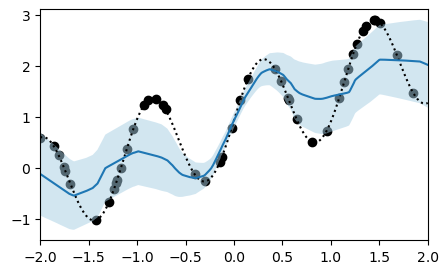

iter 21001: Avg. Loss = 0.003515839438769035
iter 22001: Avg. Loss = 0.033512019410089126
iter 23001: Avg. Loss = -0.016826057629194112
iter 24001: Avg. Loss = -0.0017535449047572911
iter 25001: Avg. Loss = 0.023140536091290416
Test loss: 0.30491326999187
iter 26001: Avg. Loss = -0.02043761198827997
iter 27001: Avg. Loss = -0.05707468234188855
iter 28001: Avg. Loss = -0.03467629110068083
iter 29001: Avg. Loss = -0.060942438809201124
iter 30001: Avg. Loss = -0.0399302536965115
Test loss: 0.28613540114759234
iter 30001: Avg. Loss SLOW = -0.1714724855303648
iter 31001: Avg. Loss = -0.06873146071945667
iter 32001: Avg. Loss = -0.10648331943069206
iter 33001: Avg. Loss = -0.08024437100451905
iter 34001: Avg. Loss = -0.09292468072799966
iter 35001: Avg. Loss = -0.10116576542548136
Test loss: 0.1548542027535732
iter 36001: Avg. Loss = -0.13343871224712348
iter 37001: Avg. Loss = -0.16505123544530942
iter 38001: Avg. Loss = -0.11990469577442854
iter 39001: Avg. Loss = -0.1327579330086446
iter 

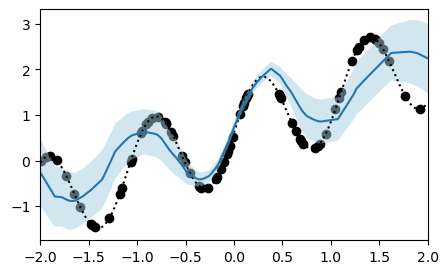

iter 41001: Avg. Loss = -0.165619188697543
iter 42001: Avg. Loss = -0.12761302274928313
iter 43001: Avg. Loss = -0.15242254867235897
iter 44001: Avg. Loss = -0.15287599566261634
iter 45001: Avg. Loss = -0.17801348240044898
Test loss: 0.18136488262697822
iter 46001: Avg. Loss = -0.15996876729209908
iter 47001: Avg. Loss = -0.16601674576062941
iter 48001: Avg. Loss = -0.22140944232034962
iter 49001: Avg. Loss = -0.20112684991420246
iter 50001: Avg. Loss = -0.20891227359272307
Test loss: 0.050539897511731394
iter 50001: Avg. Loss SLOW = -1.733978317062254
iter 51001: Avg. Loss = -0.2164829071663553
iter 52001: Avg. Loss = -0.2278175003707802
iter 53001: Avg. Loss = -0.2399787955067586
iter 54001: Avg. Loss = -0.20023427867080318
iter 55001: Avg. Loss = -0.23077487738205674
Test loss: -0.019924076988001617
iter 56001: Avg. Loss = -0.22964267335965996
iter 57001: Avg. Loss = -0.2585491270080674
iter 58001: Avg. Loss = -0.24073217285478313
iter 59001: Avg. Loss = -0.2782900936449878
iter 600

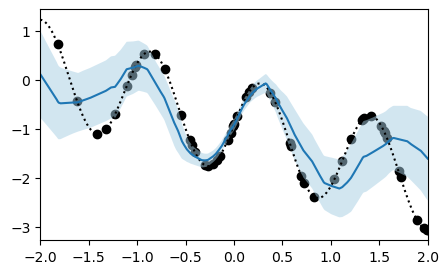

iter 61001: Avg. Loss = -0.271371211765043
iter 62001: Avg. Loss = -0.26937869704433254
iter 63001: Avg. Loss = -0.27871173075027766
iter 64001: Avg. Loss = -0.2851094917745868
iter 65001: Avg. Loss = -0.3288796736902732
Test loss: -0.1771563173137765
iter 66001: Avg. Loss = -0.30331318485265363
iter 67001: Avg. Loss = -0.2989321469105489
iter 68001: Avg. Loss = -0.3102907398403331
iter 69001: Avg. Loss = -0.3233757822956959
iter 70001: Avg. Loss = -0.34830662902223414
Test loss: -0.18965428100153803
iter 70001: Avg. Loss SLOW = -3.0176692879459788
iter 71001: Avg. Loss = -0.3382379817252513
iter 72001: Avg. Loss = -0.36793437252860167
iter 73001: Avg. Loss = -0.34506309969816357
iter 74001: Avg. Loss = -0.3325899096754438
iter 75001: Avg. Loss = -0.3682647771346383
Test loss: -0.20424726823281525
iter 76001: Avg. Loss = -0.3541943041042541
iter 77001: Avg. Loss = -0.3587296634113591
iter 78001: Avg. Loss = -0.3649200200646046
iter 79001: Avg. Loss = -0.3754528267105925
iter 80001: Avg

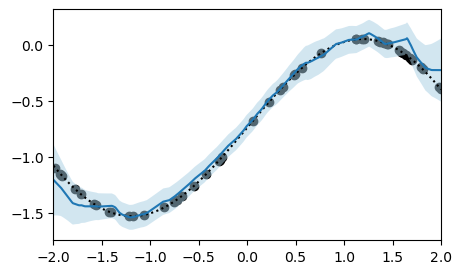

iter 81001: Avg. Loss = -0.3693386765164323
iter 82001: Avg. Loss = -0.3686273550161859
iter 83001: Avg. Loss = -0.3833341882304521
iter 84001: Avg. Loss = -0.38442382764925426
iter 85001: Avg. Loss = -0.3659960677207438
Test loss: -0.2245330428543093
iter 86001: Avg. Loss = -0.37572180388408016
iter 87001: Avg. Loss = -0.41235908507651764
iter 88001: Avg. Loss = -0.39585983261687213
iter 89001: Avg. Loss = -0.4367993911027133
iter 90001: Avg. Loss = -0.40265571999975325
Test loss: -0.3268547375870403
iter 90001: Avg. Loss SLOW = -3.8951159478130046
iter 91001: Avg. Loss = -0.40779986954992636
iter 92001: Avg. Loss = -0.43308748887258114
iter 93001: Avg. Loss = -0.42981560081485803
iter 94001: Avg. Loss = -0.40361058980517556
iter 95001: Avg. Loss = -0.4493544329133583
Test loss: -0.3339161255030194
iter 96001: Avg. Loss = -0.40251222059340214
iter 97001: Avg. Loss = -0.4315158990580676
iter 98001: Avg. Loss = -0.443063124596898
iter 99001: Avg. Loss = -0.45739217250794173
iter 100001:

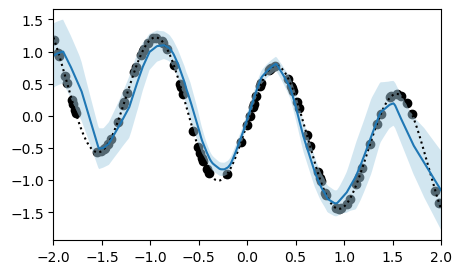

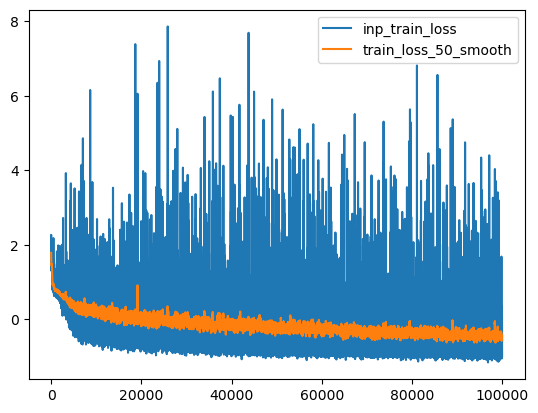

In [111]:
x_dim = 1
y_dim = 1
determ_dim = 50  # Dimension of representation of context points
latent_dim = 50  # Dimension of sampled latent variable
hidden_dim = 50  # Dimension of hidden layers in encoder and decoder
inp = NeuralProcess(x_dim=x_dim,
                   y_dim=y_dim,
                   hidden_dim=hidden_dim,
                   latent_dim=latent_dim,
                   determ_dim=determ_dim,
                   n_h_layers_decoder=3,
                   n_h_layers_phi_latent_encoder=2,
                   n_h_layers_rho_latent_encoder=1,
                   n_h_layers_phi_determ_encoder=6,
                   n_h_layers_rho_determ_encoder=0,
                   use_deterministic_path=False,
                   use_knowledge=True) # !!!
print(inp)
print(sum(p.numel() for p in inp.parameters() if p.requires_grad))

#data = SineData(max_num_context=30, random_kernel_parameters=True)
optimiser = torch.optim.Adam(inp.parameters(), lr=3e-4)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device {device}")
inp.to(device)


data = SineData(max_num_context=97, noise_scale=5e-5, return_knowledge=True)
inp_train_loss = []
inp_avg_losses = []
avg_loss_fast = 0
avg_loss_slow = 0
for iter in range(100000+1):
    inp.training = True
    optimiser.zero_grad()

    batch, knowledge = data.generate_batch(batch_size=16, device=device)
    one_hot_knowledge = generate_knowledge(knowledge, device)
    p_y_pred, loss = inp(batch.x_context, batch.y_context, batch.x_target, one_hot_knowledge, batch.y_target)

    loss.backward()
    optimiser.step()
#    with torch.no_grad():
#        test_batch, _ = data.generate_batch(batch_size=16, testing=True, device=device)
#        p_y_pred, no_knowledge_loss = inp(test_batch.x_context, test_batch.y_context, test_batch.x_target, None, test_batch.y_target)
#        inp_train_loss.append(no_knowledge_loss.item())
#        avg_loss_slow += no_knowledge_loss.item()
#        avg_loss_fast += no_knowledge_loss.item()
    inp_train_loss.append(loss.item())
    avg_loss_slow += loss.item()
    avg_loss_fast += loss.item()
    if iter % 1000 == 0 and iter > 0:
        print(f"iter {iter+1}: Avg. Loss = {avg_loss_fast/1000}")
        #print(f"iter. loss = {loss.item()}, iter. Loss2 (not being backpropped on) = {loss2.item()}")
        avg_loss_fast = 0 
    if iter % 5000 == 0:
        inp_avg_losses.append(test(inp, num_batches=1000))
    if iter % 10000 == 0 and iter > 0:
        print(f"iter {iter+1}: Avg. Loss SLOW = {avg_loss_slow/1000}")
        avg_loss_slow = 0 
    if iter % 20000 == 0:
        inp.training = False
        batch, knowledge = data.generate_batch(batch_size=1, testing=True, device=inp.device)
        plot_predictive(inp, batch, knowledge=None, save=False, iter=None)
        inp.training = True

plt.plot(inp_train_loss, label='inp_train_loss')
window = 50
plt.plot([sum(inp_train_loss[i:i+window])/window for i in range(len(inp_train_loss)-window)], label=f'train_loss_{window}_smooth')
plt.legend()
plt.show()

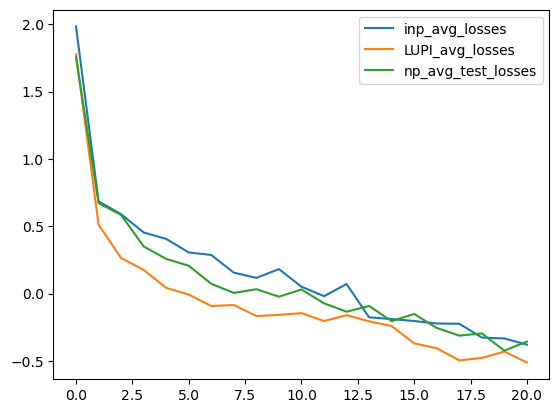

In [120]:
plt.plot(inp_avg_losses, label='inp_avg_losses')
plt.plot(LUPI_np_avg_losses, label='LUPI_avg_losses')
plt.plot(np_avg_test_losses, label='np_avg_test_losses')
plt.legend()
plt.show()